In [192]:
#import matplotlib.pyplot as plt
from datetime import date
import jax
from jax import jit
import jax.numpy as jnp
import flax.linen as nn
import distrax
import jax.scipy.stats as stats
import optax

from src.resnet_groupnorm import *
from src.kernels import *
from src.cifar_train_test import *
from src.utils import *
from sklearn.metrics import classification_report

In [2]:
import orbax.checkpoint as ocp
import os
import shutil
from flax.training import orbax_utils
import orbax


In [3]:
model=ResNet(num_classes= 10,
               c_hidden= (16, 32, 64),
               num_blocks= (3, 3, 3),
               act_fn= nn.relu,
               block_class= ResNetBlock)

In [ ]:
model.tabulate(rngs, x, train=True, console_kwargs={"force_jupyter": True})

In [4]:
X, y = next(iter(train_loader))
print("Batch mean", X.mean(axis=(0,1,2)))
print("Batch std", X.std(axis=(0,1,2)))

Batch mean [ 0.00573762 -0.01562549 -0.03281149]
Batch std [0.94382892 0.92911948 0.94728441]


In [ ]:
model.tabulate(rngs, x, train=True, console_kwargs={"force_jupyter": True})

In [4]:
def log_prior(params):
    leaves, _ = jax.tree_util.tree_flatten(params)
    flat_params = jnp.concatenate([jnp.ravel(a) for a in leaves])
    return distrax.Normal(0., 10.).log_prob(flat_params).sum()/len(train_set)

def loglikelihood(params,batch,train=True):
    X, y = batch
    outs= model.apply({'params':params}, 
                                         X,
                                         train=train)
    logits = outs 
    dist=distrax.Categorical(logits=logits)
    nll=-1.0*jnp.mean(dist.log_prob(y))
    return nll 

def log_posterior(params,batch):
    nll=loglikelihood(params,batch)
    return nll-log_prior(params)

def acc_top1(params,data_loader):
    y_pred=list()
    y_true=list()
    for batch in data_loader:
        X, y = batch
        X_batch=jnp.array(X)
        y_batch=jnp.array(y)
        prediction = model.apply({'params':params}, X_batch, train=False, mutable=False)
        y_pred.append(jnp.argmax(prediction, axis=1))
        y_true.append(y_batch)
    y_pred=jnp.concatenate(y_pred)
    y_true=jnp.concatenate(y_true)   
    return jnp.mean(y_pred == y_true)

In [5]:
from functools import partial 

grad_log_post=jax.jit(jax.value_and_grad(log_posterior))

In [22]:
curdir = os.getcwd()
ckpt_dir =os.path.join(curdir,'posterior_samples')

if os.path.exists(ckpt_dir):
    shutil.rmtree(ckpt_dir)  

options = orbax.checkpoint.CheckpointManagerOptions(save_interval_steps=len(train_set)//batch_size,max_to_keep=100, create=True)
manager = ocp.CheckpointManager(ckpt_dir, options=options)

In [24]:
learning_rate=1e-5
n_epochs=200

key = jax.random.PRNGKey(10)
key, subkey = jax.random.split(key)
variables = model.init(subkey, jnp.array(X),train=True)
params = variables['params']
momemtum=jax.tree_util.tree_map(lambda p:jnp.zeros_like(p),params)
kernel=jit(psgld_momemtum)
num_iter=0
for j in range(n_epochs):
    for i,(X,y) in enumerate(train_loader):
        #learning_rate=learning_rate*0.99
        X_batch,y_batch=jnp.array(X),jnp.array(y)
        nll,grads=grad_log_post(params,(X_batch,y_batch))
        #batch_stats=new_state['batch_stats']
        key,params,momemtum=kernel(key,params,momemtum,grads,learning_rate)
        position={'params':params}
        #samples.append(position)
        manager.save(num_iter,args=ocp.args.StandardSave(position))
        num_iter+=1
    if (j%(n_epochs//10)==0):
        logits=model.apply({'params':params},X_batch,train=False,mutable=False)
        accuracy = (logits.argmax(axis=-1) == y_batch).mean()
        nll=loglikelihood(params,(X_batch,y_batch),train=False)
        val_accuracy=acc_top1(params,val_loader)
        print('Epoch {0}, Log-likelihood : {1:8.2f}, Train Accuracy : {2:8.2f}, Val Accuracy {3:8.2f}: '.
              format(j,nll,accuracy,val_accuracy))
    

Epoch 0, Log-likelihood :     1.52, Train Accuracy :     0.52, Val Accuracy     0.46: 
Epoch 20, Log-likelihood :     0.70, Train Accuracy :     0.77, Val Accuracy     0.71: 
Epoch 40, Log-likelihood :     0.50, Train Accuracy :     0.86, Val Accuracy     0.76: 
Epoch 60, Log-likelihood :     0.42, Train Accuracy :     0.88, Val Accuracy     0.79: 
Epoch 80, Log-likelihood :     0.29, Train Accuracy :     0.94, Val Accuracy     0.80: 
Epoch 100, Log-likelihood :     0.43, Train Accuracy :     0.86, Val Accuracy     0.81: 
Epoch 120, Log-likelihood :     0.33, Train Accuracy :     0.87, Val Accuracy     0.82: 
Epoch 140, Log-likelihood :     0.33, Train Accuracy :     0.89, Val Accuracy     0.81: 
Epoch 160, Log-likelihood :     0.29, Train Accuracy :     0.91, Val Accuracy     0.81: 
Epoch 180, Log-likelihood :     0.28, Train Accuracy :     0.90, Val Accuracy     0.84: 


In [26]:
acc_top1(params,test_loader)

Array(0.8168, dtype=float32)

In [8]:
curdir = os.getcwd()
ckpt_dir =os.path.join(curdir,'posterior_samples')

options = orbax.checkpoint.CheckpointManagerOptions(save_interval_steps=len(train_set)//batch_size,max_to_keep=100, create=True)
manager = ocp.CheckpointManager(ckpt_dir, options=options)

last_ckpt=manager.all_steps()[0]
restored = manager.restore(last_ckpt)
acc_top1(restored['params'],test_loader)

Array(0.8055, dtype=float32)

# Quantization

In [10]:
sgld_samples = [manager.restore(ckpt) for ckpt in manager.all_steps()]

In [11]:
len(sgld_samples)

100

In [ ]:
stacked_samples=tree_stack(sgld_samples)
alpha=jax.tree.map(lambda p:jnp.min(p),stacked_samples)
beta=jax.tree.map(lambda p:jnp.max(p),stacked_samples)
b=8
alpha_q = 0
beta_q = 255
s=jax.tree.map(lambda a,b:generate_quantization_constants_scale(a,b,alpha_q,beta_q),alpha,beta)
z=jax.tree.map(lambda a,b:generate_quantization_constants_bias(a,b,alpha_q,beta_q),alpha,beta)

In [13]:
quantized_stacked_samples=jax.tree.map(lambda x,s,z:quantization(x,s,z,alpha_q,beta_q),stacked_samples,s,z)

In [14]:
dequantized_stacked_samples=jax.tree.map(
    lambda x,s,z:dequantization(x,s,z),quantized_stacked_samples,s,z)

(array([   64.,   563.,  2070.,  5637., 12426., 12159.,  7485.,  2071.,
          526.,   199.]),
 array([-2.03645515, -1.63580036, -1.23514557, -0.83449078, -0.43383598,
        -0.03318119,  0.3674736 ,  0.7681284 ,  1.16878319,  1.56943798,
         1.97009254]),
 <BarContainer object of 10 artists>)

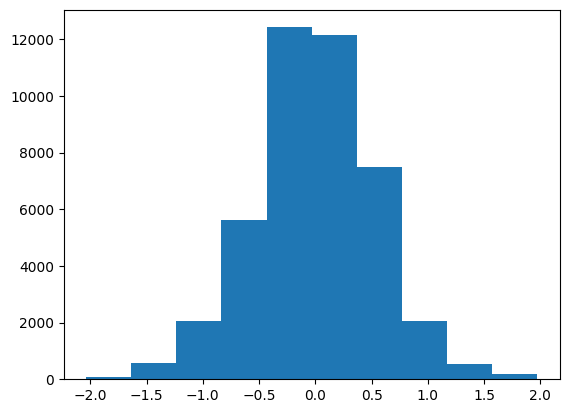

In [15]:
import matplotlib.pyplot as plt

plt.hist(stacked_samples['params']['Conv_0']['kernel'].ravel())

(array([   86.,   650.,  2173.,  5838., 12951., 11671.,  7125.,  1987.,
          517.,   202.]),
 array([-1.99541795, -1.59947681, -1.20353556, -0.80759442, -0.41165316,
        -0.0157119 ,  0.38022912,  0.77617037,  1.17211163,  1.56805289,
         1.96399403]),
 <BarContainer object of 10 artists>)

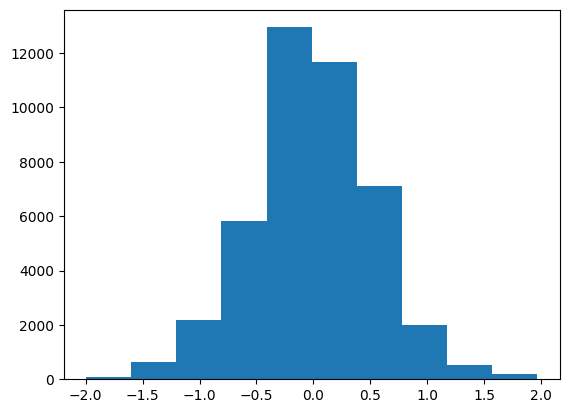

In [16]:
plt.hist(dequantized_stacked_samples['params']['Conv_0']['kernel'].ravel())

In [17]:
def print_pytree(tree, name="tree"):
    """Prints the structure and values of a JAX pytree."""
    print(f"--- Printing PyTree: {name} ---")
    flattened, _ = jax.tree_util.tree_flatten_with_path(tree)
    for key_path, value in flattened:
        path_str = jax.tree_util.keystr(key_path)
        print(f"{name}{path_str}: {value}")
    print("-" * (len(name) + 22))

print_pytree(jax.tree.map(lambda p,q:jnp.linalg.norm(p-q),dequantized_stacked_samples,stacked_samples))

--- Printing PyTree: tree ---
tree['params']['Conv_0']['kernel']: 0.9433205127716064
tree['params']['Dense_0']['bias']: 0.08297566324472427
tree['params']['Dense_0']['kernel']: 1.1556974649429321
tree['params']['GroupNorm_0']['bias']: 0.08712537586688995
tree['params']['GroupNorm_0']['scale']: 0.07360761612653732
tree['params']['ResNetBlock_0']['Conv_0']['kernel']: 3.4633851051330566
tree['params']['ResNetBlock_0']['Conv_1']['kernel']: 3.201885461807251
tree['params']['ResNetBlock_0']['GroupNorm_0']['bias']: 0.1047007143497467
tree['params']['ResNetBlock_0']['GroupNorm_0']['scale']: 0.07820054888725281
tree['params']['ResNetBlock_0']['GroupNorm_1']['bias']: 0.07333925366401672
tree['params']['ResNetBlock_0']['GroupNorm_1']['scale']: 0.07100565731525421
tree['params']['ResNetBlock_1']['Conv_0']['kernel']: 2.9330012798309326
tree['params']['ResNetBlock_1']['Conv_1']['kernel']: 3.2938249111175537
tree['params']['ResNetBlock_1']['GroupNorm_0']['bias']: 0.11136074364185333
tree['params']['R

In [18]:
dequantized_samples=tree_unstack(dequantized_stacked_samples)

In [20]:
fp32_size=sum(jax.tree.flatten(jax.tree.map(lambda p:p.nbytes,stacked_samples))[0])*1e-6

In [21]:
int8_size=sum(jax.tree.flatten(jax.tree.map(lambda p:p.nbytes,quantized_stacked_samples))[0])*1e-6

# Pruebas Clasificación

In [40]:
def ensemble_acc_top1(params,data_loader):
    y_pred=list()
    y_true=list()
    for batch in data_loader:
        X, y = batch
        X_batch=jnp.array(X)
        y_batch=jnp.array(y)
        prediction = model.apply({'params':params}, X_batch, train=False)
        y_pred.append(prediction)
        y_true.append(y_batch)
    y_pred=jnp.concatenate(y_pred)
    y_true=jnp.concatenate(y_true)   
    return y_pred,y_true

In [194]:
len(sgld_samples)

100

In [195]:
ensemble_pred=list()
for sample in sgld_samples:
    y_pred,y_true = ensemble_acc_top1(sample['params'],test_loader)
    ensemble_pred.append(y_pred)

In [196]:
ensemble_pred=jnp.stack(ensemble_pred)

In [204]:
mean_pred=jnp.mean(ensemble_pred,axis=0)

In [205]:
mean_pred.shape

(10000, 10)

In [206]:
from sklearn.metrics import classification_report

print(classification_report(np.array(y_true), np.asarray(mean_pred.argmax(axis=1))))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1000
           1       0.94      0.93      0.94      1000
           2       0.82      0.79      0.80      1000
           3       0.78      0.67      0.72      1000
           4       0.83      0.86      0.85      1000
           5       0.82      0.76      0.79      1000
           6       0.81      0.93      0.87      1000
           7       0.89      0.89      0.89      1000
           8       0.94      0.90      0.92      1000
           9       0.90      0.92      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [ ]:
ece_samples=expected_calibration_error_jax(jax.nn.softmax(mean_pred,axis=0), y_true, M=5)

Array([0.77011055], dtype=float32)

np.float64(0.014478885079531108)

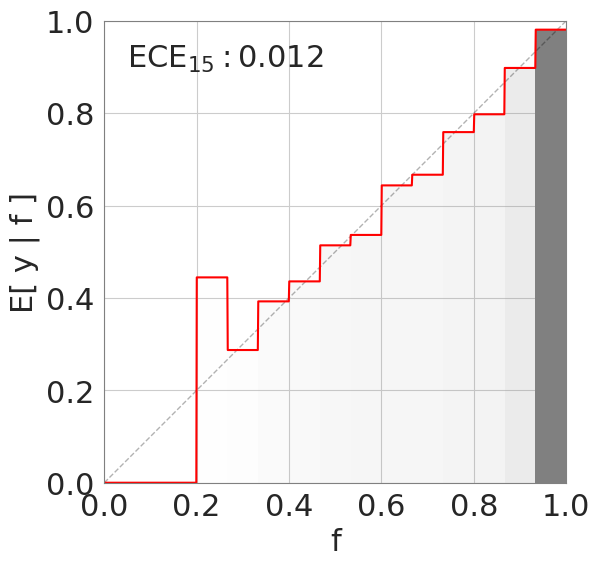

In [264]:
import relplot 

conf, acc = relplot.multiclass_logits_to_confidences(mean_pred, y_true) # reduce to binary setting
relplot.rel_diagram_binned(f=conf, y=acc) # plot confidence calibration diagram
relplot.smECE(f=conf, y=acc) # compute smECE of confidence calibration

In [233]:
quantized_ensemble_pred=list()
for sample in dequantized_samples:
    y_pred,y_true = ensemble_acc_top1(sample['params'],test_loader)
    quantized_ensemble_pred.append(y_pred)

In [266]:
len(quantized_ensemble_pred)

100

In [235]:
quantized_ensemble_pred=jnp.stack(quantized_ensemble_pred)
qmean_pred=jnp.mean(quantized_ensemble_pred,axis=0)
print(classification_report(np.array(y_true), np.asarray(qmean_pred.argmax(axis=1))))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1000
           1       0.94      0.94      0.94      1000
           2       0.82      0.79      0.80      1000
           3       0.77      0.67      0.72      1000
           4       0.83      0.86      0.85      1000
           5       0.82      0.76      0.79      1000
           6       0.81      0.93      0.86      1000
           7       0.90      0.90      0.90      1000
           8       0.94      0.90      0.92      1000
           9       0.90      0.92      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.85     10000
weighted avg       0.86      0.86      0.85     10000



np.float64(0.013348927185102019)

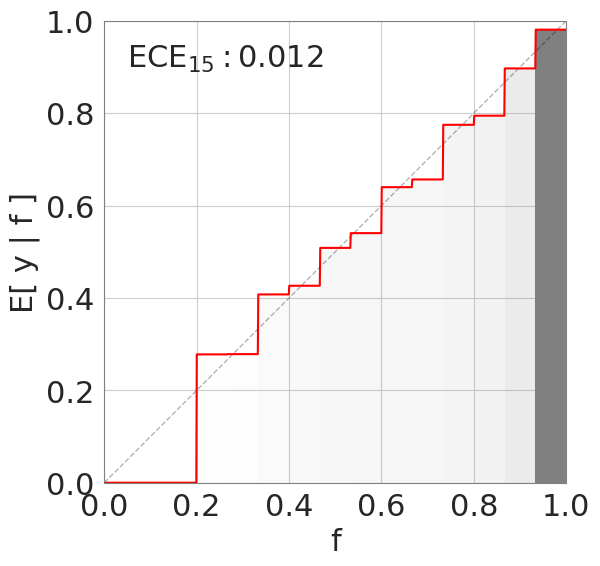

In [245]:
conf, acc = relplot.multiclass_logits_to_confidences(qmean_pred, y_true) # reduce to binary setting
relplot.rel_diagram_binned(f=conf, y=acc) # plot confidence calibration diagram
relplot.smECE(f=conf, y=acc) # compute smECE of confidence calibration

# Metricas de Muestreo

In [41]:
from kernax import SteinThinning

In [73]:
def ensemble_log_probs(params,data_loader):
    for batch in data_loader:
        X, y = batch
        X_batch=jnp.array(X)
        y_batch=jnp.array(y)
        nll,grads=grad_log_post(params,(X_batch,y_batch))
        break
    return nll,grads

In [79]:
nll_list=list()
grads_list=list()
for sample in sgld_samples:
    ll,gg=ensemble_log_probs(sample['params'],test_loader)
    nll_list.append(ll)
    grads_list.append(gg)

In [82]:
stacked_grads=tree_stack(grads_list)
flatten_scores=jax.tree.map(lambda p:p.reshape(100,-1),stacked_grads)

In [83]:
from kernax.utils import median_heuristic

flatten_stacked_samples=jax.tree.map(lambda p:p.reshape(100,-1),stacked_samples)
length_scales=jax.tree.map(lambda p:median_heuristic(p),flatten_stacked_samples)

In [139]:
indices=jax.tree.map(lambda x,s,l:SteinThinning(x,s,l)(30),flatten_stacked_samples['params'],flatten_scores,length_scales['params'])

In [156]:
all_indices=jnp.stack(jax.tree_util.tree_leaves(indices))
voted_indices,counts=jnp.unique(all_indices,return_counts=True)
thinned_indices=[voted_indices[i] for i in counts.argsort(descending=True)][:30]
thinned_indices=jnp.stack(thinned_indices)
thinned_samples=[sgld_samples[i] for i in thinned_indices]

In [239]:
thinned_ensemble_pred=list()
for sample in thinned_samples:
    y_pred,y_true = ensemble_acc_top1(sample['params'],test_loader)
    thinned_ensemble_pred.append(y_pred)

In [242]:
from sklearn.metrics import classification_report

thinned_ensemble_pred=jnp.stack(thinned_ensemble_pred)
thinned_pred=jnp.median(thinned_ensemble_pred,axis=0)
print(classification_report(np.array(y_true), np.asarray(thinned_pred.argmax(axis=1))))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1000
           1       0.94      0.94      0.94      1000
           2       0.79      0.81      0.80      1000
           3       0.74      0.68      0.71      1000
           4       0.85      0.85      0.85      1000
           5       0.84      0.71      0.77      1000
           6       0.81      0.92      0.86      1000
           7       0.88      0.89      0.88      1000
           8       0.94      0.89      0.91      1000
           9       0.88      0.93      0.90      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



np.float64(0.014251935727013361)

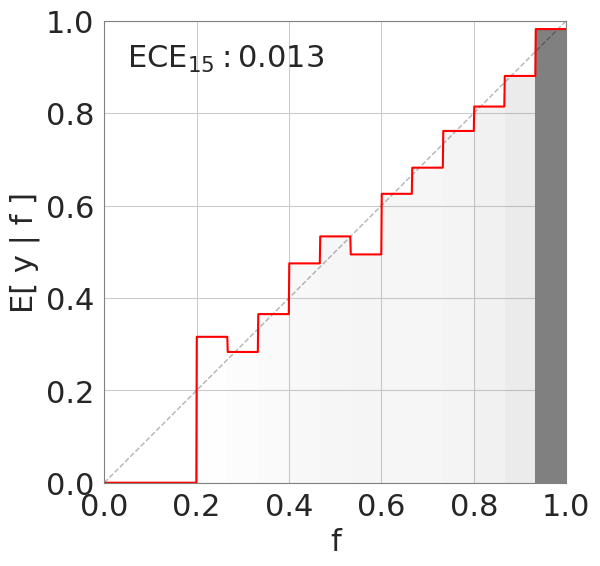

In [249]:
conf, acc = relplot.multiclass_logits_to_confidences(thinned_pred, y_true) # reduce to binary setting
relplot.rel_diagram_binned(f=conf, y=acc) # plot confidence calibration diagram
relplot.smECE(f=conf, y=acc) # compute smECE of confidence calibration

In [160]:
stacked_thinned_samples=tree_stack(thinned_samples)
thinned_size=sum(jax.tree.flatten(jax.tree.map(lambda p:p.nbytes,stacked_thinned_samples))[0])*1e-6

In [161]:
print('Tamaño Muestras FP32 : {0:.2f}Mb'.format(fp32_size))
print('Tamaño Muestras INT8 : {0:.2f}Mb'.format(int8_size))
print('Tamaño Muestras Thinning : {0:.2f}Mb'.format(thinned_size))

Tamaño Muestras FP32 : 108.95Mb
Tamaño Muestras INT8 : 27.24Mb
Tamaño Muestras Thinning : 32.69Mb


# Thinning + Quantization

In [165]:
alpha=jax.tree.map(lambda p:jnp.min(p),stacked_thinned_samples)
beta=jax.tree.map(lambda p:jnp.max(p),stacked_thinned_samples)
b=8
alpha_q = 0
beta_q = 255
s=jax.tree.map(lambda a,b:generate_quantization_constants_scale(a,b,alpha_q,beta_q),alpha,beta)
z=jax.tree.map(lambda a,b:generate_quantization_constants_bias(a,b,alpha_q,beta_q),alpha,beta)

In [186]:
quantized_thinned_stacked_samples=jax.tree.map(lambda x,s,z:quantization(x,s,z,alpha_q,beta_q),stacked_thinned_samples,s,z)
dequantized_thinned_stacked_samples=jax.tree.map(
    lambda x,s,z:dequantization(x,s,z),quantized_thinned_stacked_samples,s,z)
dequantized_thinned_samples=tree_unstack(dequantized_thinned_stacked_samples)
#dequantized_thinned_samples=tree_unstack(dequantized_thinned_stacked_samples)

In [187]:
quantized_thinned_size=sum(jax.tree.flatten(jax.tree.map(lambda p:p.nbytes,quantized_thinned_stacked_samples))[0])*1e-6

In [260]:
quantized_thinned_pred=list()
for sample in dequantized_thinned_samples:
    y_pred,y_true = ensemble_acc_top1(sample['params'],test_loader)
    quantized_thinned_pred.append(y_pred)

(array([  24.,  198.,  630., 1757., 3886., 3570., 2084.,  615.,  135.,
          61.]),
 array([-1.99541795, -1.59947681, -1.20353556, -0.80759442, -0.41165316,
        -0.0157119 ,  0.38022912,  0.77617037,  1.17211163,  1.56805289,
         1.96399403]),
 <BarContainer object of 10 artists>)

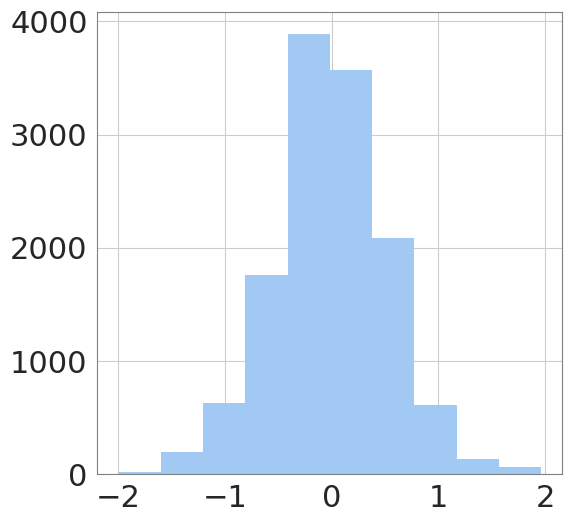

In [259]:
plt.hist(dequantized_thinned_stacked_samples['params']['Conv_0']['kernel'].ravel())

In [261]:
quantized_thinned_pred=jnp.stack(quantized_thinned_pred)
quantized_thinned_pred=jnp.median(quantized_thinned_pred,axis=0)
print(classification_report(np.array(y_true), np.asarray(quantized_thinned_pred.argmax(axis=1))))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1000
           1       0.94      0.94      0.94      1000
           2       0.80      0.80      0.80      1000
           3       0.75      0.67      0.71      1000
           4       0.85      0.84      0.85      1000
           5       0.84      0.71      0.77      1000
           6       0.80      0.93      0.86      1000
           7       0.87      0.89      0.88      1000
           8       0.94      0.89      0.91      1000
           9       0.88      0.93      0.90      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



np.float64(0.013057464950455181)

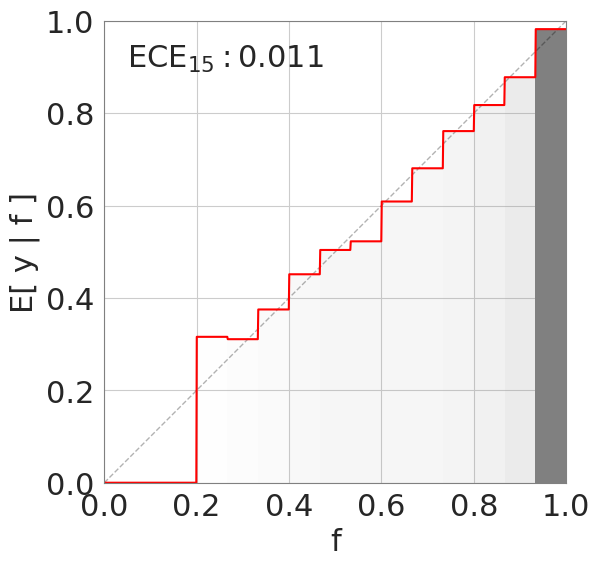

In [262]:
conf, acc = relplot.multiclass_logits_to_confidences(quantized_thinned_pred, y_true) # reduce to binary setting
relplot.rel_diagram_binned(f=conf, y=acc) # plot confidence calibration diagram
relplot.smECE(f=conf, y=acc) # compute smECE of confidence calibration

In [191]:
print('Tamaño Muestras FP32 : {0:.2f}Mb'.format(fp32_size))
print('Tamaño Muestras INT8 : {0:.2f}Mb'.format(int8_size))
print('Tamaño Muestras Thinning : {0:.2f}Mb'.format(thinned_size))
print('Tamaño Muestras Quantization+Thinning : {0:.2f}Mb'.format(quantized_thinned_size))

Tamaño Muestras FP32 : 108.95Mb
Tamaño Muestras INT8 : 27.24Mb
Tamaño Muestras Thinning : 32.69Mb
Tamaño Muestras Quantization+Thinning : 8.17Mb
